In [75]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [76]:
data = pd.read_csv('C:/DS/ML_2/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


age — возраст страхователя;
sex — пол;
bmi — индекс массы тела (
к
г
м
), в идеале — от 18.5 до 24.9;
children — количество детей, охваченных медицинской страховкой;
smoker — является ли человек курящим;
region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [77]:
print(data.shape)

(1338, 7)


In [78]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [79]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [80]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

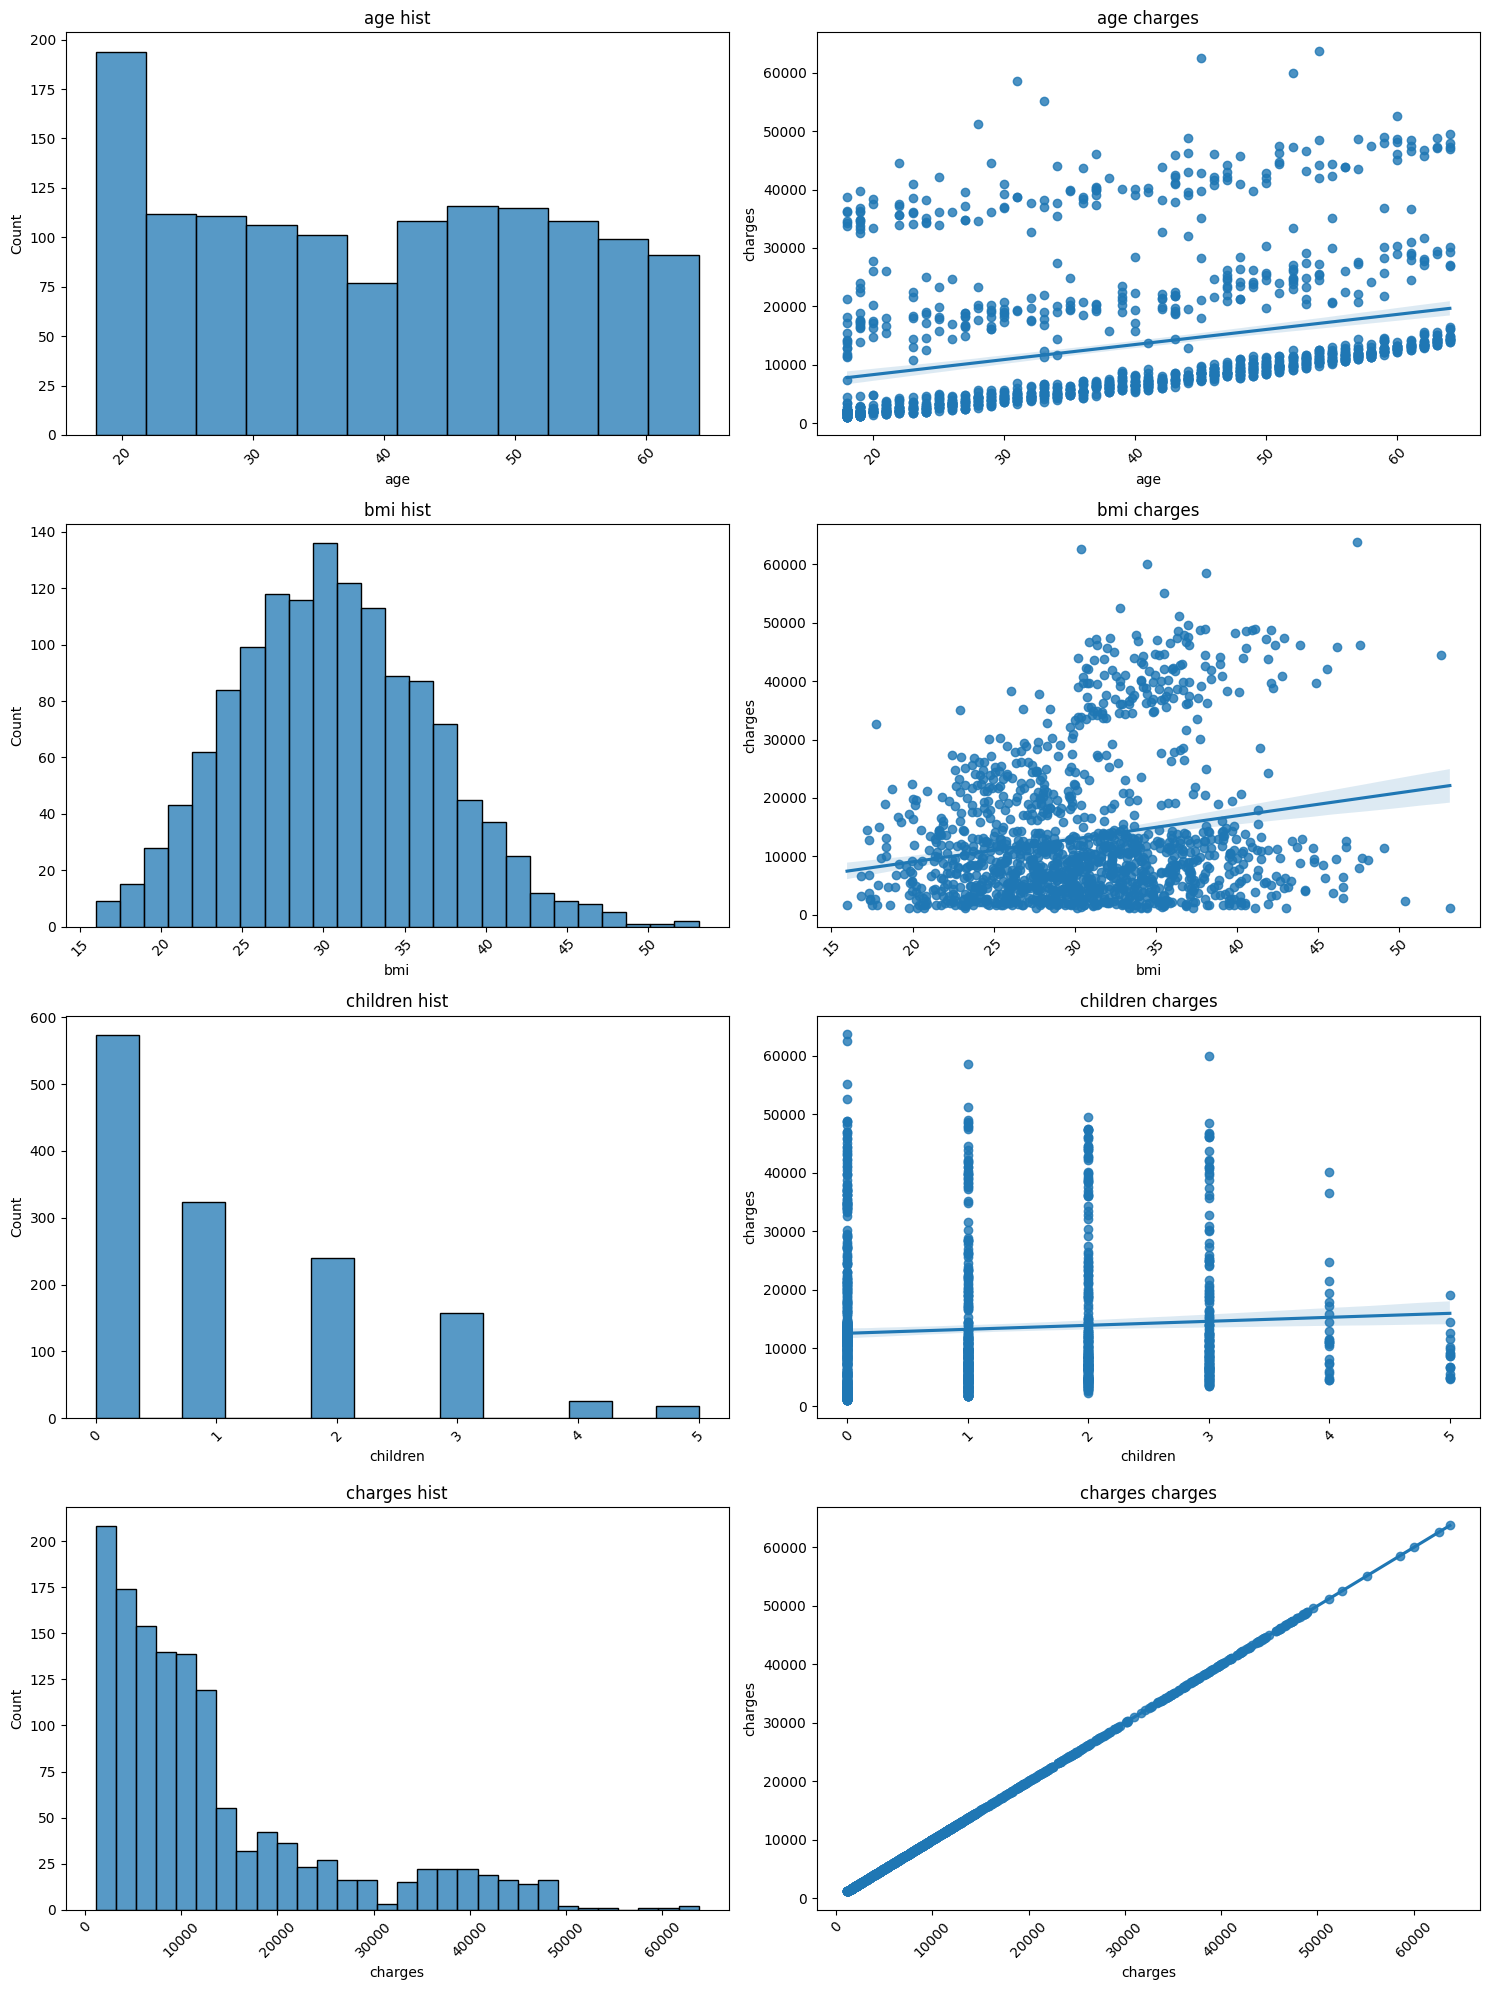

In [81]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

<Axes: >

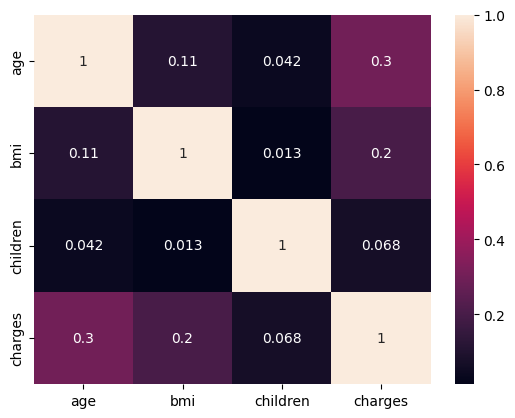

In [82]:
sns.heatmap(data.corr(numeric_only=True), annot=True)

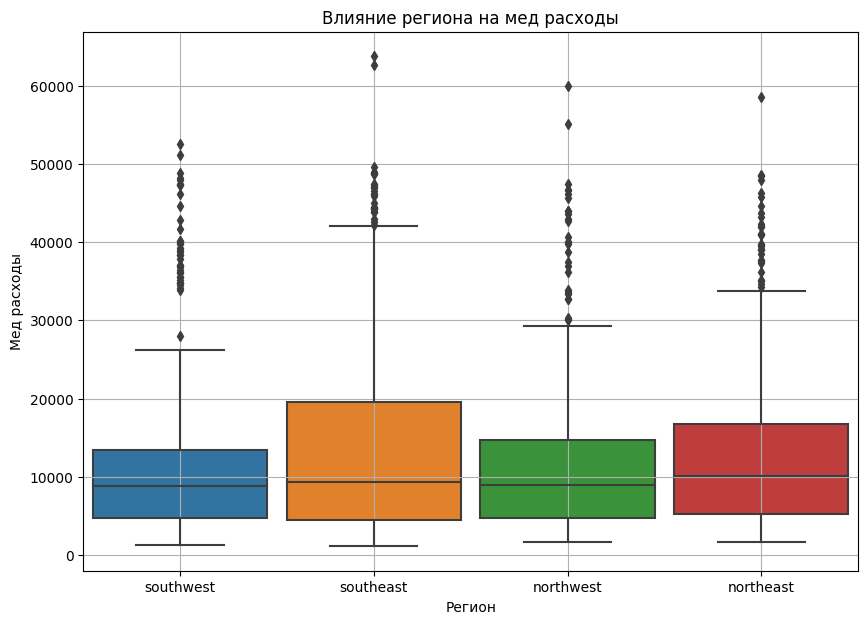

In [83]:
fig=plt.figure(figsize=(10,7))
boxplot = sns.boxplot(
    data=data,
    y='charges',
    x='region',
    orient='v',
    width=0.9
)
#balance_exited.info()
boxplot.set_title('Влияние региона на мед расходы')
boxplot.set_xlabel('Регион')
boxplot.set_ylabel('Мед расходы')
boxplot.grid()
plt.show()

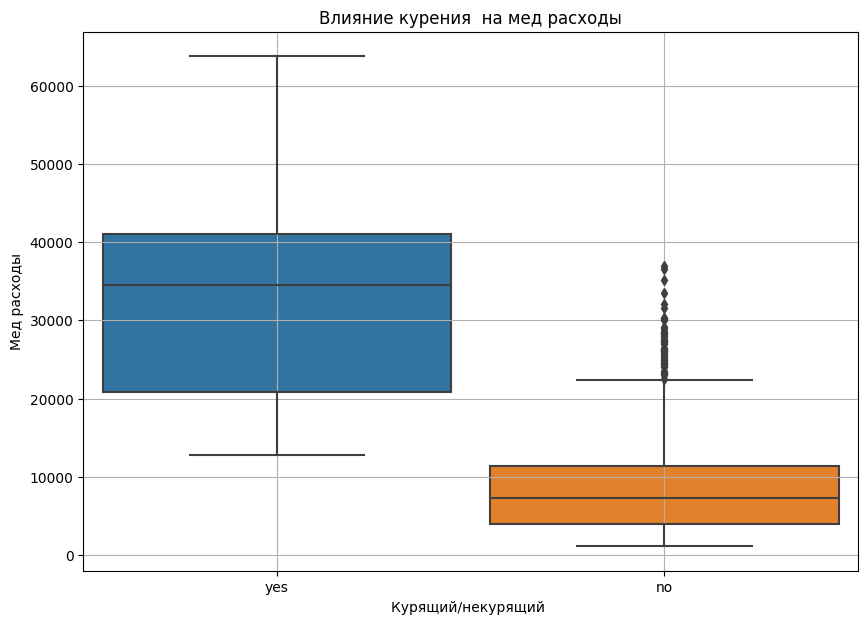

In [84]:
fig=plt.figure(figsize=(10,7))
boxplot = sns.boxplot(
    data=data,
    y='charges',
    x='smoker',
    orient='v',
    width=0.9
)
#balance_exited.info()
boxplot.set_title('Влияние курения  на мед расходы')
boxplot.set_xlabel('Курящий/некурящий ')
boxplot.set_ylabel('Мед расходы')
boxplot.grid()
plt.show()

В соответствии с этим алгоритмом напишем функцию outliers_iqr(), которая вам может ещё не раз пригодиться в реальных задачах. Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.


In [85]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr(data,'charges')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 139
Результирующее число записей: 1199


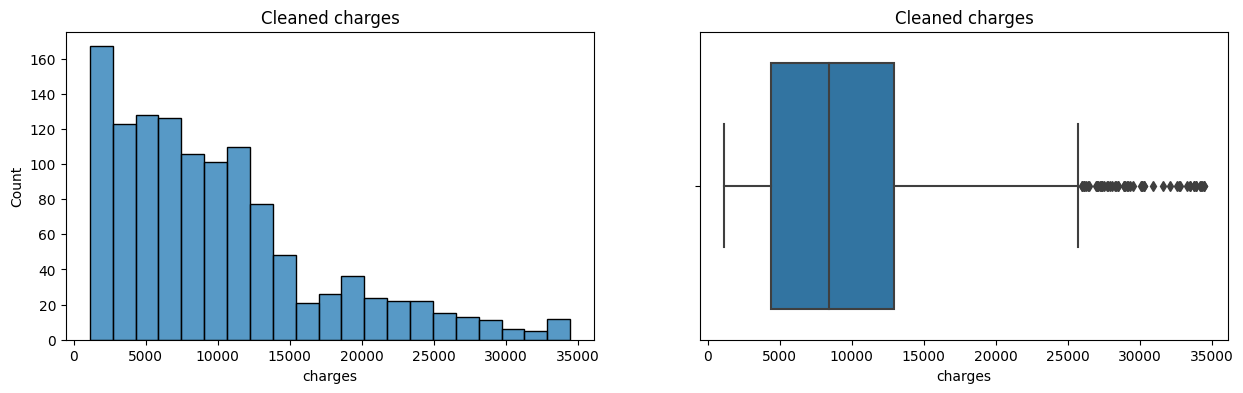

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='charges', ax=axes[0]);
histplot.set_title('Cleaned charges');
boxplot = sns.boxplot(data=cleaned, x='charges', ax=axes[1]);
boxplot.set_title('Cleaned charges');

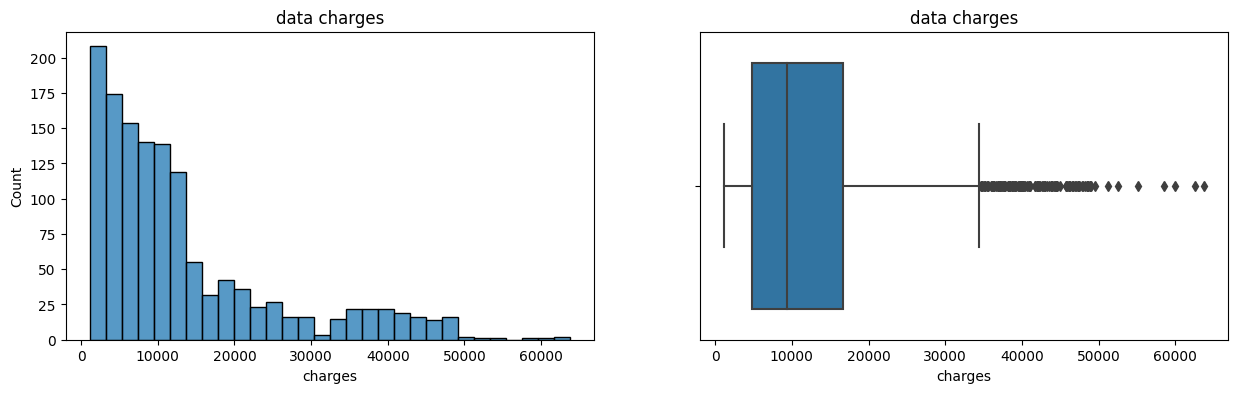

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='charges', ax=axes[0]);
histplot.set_title('data charges');
boxplot = sns.boxplot(data=data, x='charges', ax=axes[1]);
boxplot.set_title('data charges');

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
sex — аналогично (0 — female, 1 — male);
region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [88]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


Выделим факторы и целевой признак в отдельные таблицы:

In [89]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

Задание 6.1
1 point possible (graded)
Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

Чему равно количество наблюдений в тестовом наборе данных?

In [90]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


Задание 6.2
1 point possible (graded)
Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [91]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
print('w0: {:.2F}'.format(lr.intercept_)) #свободный член w0
print('w1: {}'.format(lr.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: -12390.80
w1: [ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


Задание 6.3
6 points possible (graded)
С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики:R2 ,MAE ,MAPE . Не забудьте привести значение MAPE  к процентам.

Значение R2 округлите до трёх знаков после точки-разделителя, а значения MAE и MAPE — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [92]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [93]:
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Test MAPE: 47


Задание 6.4
1 point possible (graded)

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: y-y^ (без модуля).

Выберите верные ответы:
A Разброс ошибок на тестовой выборке больше, чем на тренировочной.
B Разброс ошибок на тренировочной выборке больше, чем на тестовой.(ВЕРНО)
C Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).(ВЕРНО)
D Медианная ошибка на тренировочной и тестовой выборках положительная (больше 0)

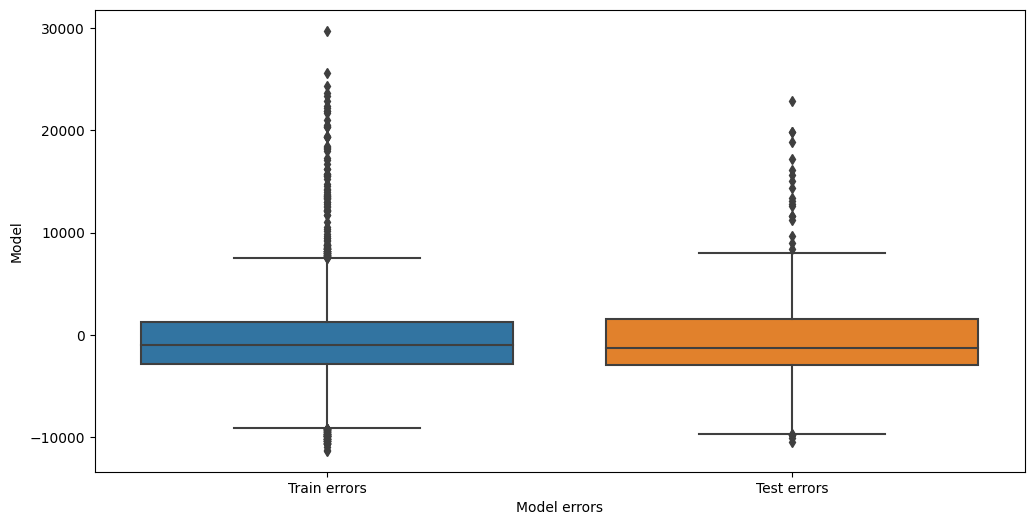

In [94]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Задание 6.5
1 point possible (graded)
Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

In [95]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [96]:
#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


Задание 6.6
1 point possible (graded)
Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики R2 на тестовой выборке?

Значение R2 округлите до трёх знаков после запятой.

R2:

In [97]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2906
Train MAPE: 30


Test R^2: 0.867
Test MAE: 2742
Test MAPE: 30


Задание 6.7
1 point possible (graded)

Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.(ВЕРНО)
Значения коэффициентов приемлемые, модель устойчива, регуляризация не нужна.
нет ответа
Отправить

In [98]:
coef=lr_poly.coef_
print(coef)

[-3.51760358e+16  1.61021746e+15  2.47615914e+15 -4.81004112e+15
  1.29275952e+14 -3.52012791e+15 -2.48431178e+15 -2.59881721e+15
 -1.45044066e+15  8.44800000e+03  8.02000000e+02  9.72000000e+02
 -1.67600000e+03  1.70000000e+02  3.51760358e+16  3.51760358e+16
  3.51760358e+16  3.51760358e+16 -9.23535566e+14  6.51750000e+02
 -1.23750000e+03  2.63000000e+02 -6.86681899e+14 -6.86681899e+14
 -6.86681899e+14 -6.86681899e+14 -9.69775000e+03  1.55693750e+03
  5.48399844e+04 -2.47615914e+15 -2.47615914e+15 -2.47615914e+15
 -2.47615914e+15 -2.09825000e+03 -2.23150000e+03  4.81004112e+15
  4.81004112e+15  4.81004112e+15  4.81004112e+15  2.54047741e+13
 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14
 -1.14203819e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.17785432e+15  0.00000000e+00  0.00000000e+00 -2.06334889e+15
  0.00000000e+00 -3.21172544e+15]


Задание 6.8
3 points possible (graded)
Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики ,  и  на тестовой выборке?

Значение  округлите до трёх знаков после запятой, а значения  и  до целого числа.
Главный параметр инициализации Lasso — это alpha, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. 

In [99]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2906
Train MAPE: 30


Test R^2: 0.867
Test MAE: 2742
Test MAPE: 30


Задание 6.9
3 points possible (graded)
Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики ,  и  на тестовой выборке?

Значение  округлите до трёх знаков после запятой, а значения  и  до целого числа.

:

  нет ответа 
 
, $:

  нет ответа 
 
, %:

  нет ответа 
 

In [100]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2906
Train MAPE: 30


Test R^2: 0.867
Test MAE: 2742
Test MAPE: 30
